# Global Automotive Parts Pricing – End-to-End ETL & Analytics Pipeline

# Project Overview 

This project builds an end-to-end ETL pipeline for global automotive parts listings.
Raw CSV files (applications, vehicles, sellers, categories, etc.) are ingested, cleaned, and joined into an analytics-ready dataset.

On top of this, a simple pricing engine is implemented in Python to:

Simulate market pricing using historical listing data.
Estimate recommended price for each listing based on:

    Item condition (New / Used),
    
    Market median price in the same category,
    
    Seller status (VIP / Super VIP, etc.).
    
Calculate profit margins and position vs market (cheap / fair / overpriced).

Finally, the processed data is transformed into a Star Schema (fact + dimension tables) that can be easily loaded into Power BI / Tableau / Excel for dashboards on:

Regional sales performance (via seller address),

Price distribution by category / vehicle / condition,

Pricing elasticity and competitiveness.

# GitHub Repository:  

# Streamlit App: https://akdas-ds-end-to-end-etl-analytics-pipeline-app-dpxjoj.streamlit.app/

In [1]:
# 1. Import all the libraries that  we will be using 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

# This makes plots look a bit nicer inside Jupyter
plt.style.use("ggplot")

# 2. Showing all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

# 3. Set a base data folder (CHANGE this to your actual path if needed)
DATA_DIR = Path(".")  # if your CSVs are in the same folder as the notebook
# Example:
# DATA_DIR = Path(r"C:\Users\YourName\Downloads\auto_parts_dataset")


In [7]:
# Helper function so that if something fails, we get a clear error message
def load_csv(file_name):
    file_path = DATA_DIR / file_name
    print(f"Loading {file_path}")
    return pd.read_csv(file_path)

applications = load_csv("applications.csv")
application_status = load_csv("application_status.csv")
seller = load_csv("seller.csv")
product_category = load_csv("product_category.csv")
vehicles = load_csv("vehicles.csv")
vehicle_type = load_csv("vehicle_type.csv")
compatibility = load_csv("compatibility.csv")


Loading applications.csv
Loading application_status.csv
Loading seller.csv
Loading product_category.csv
Loading vehicles.csv
Loading vehicle_type.csv
Loading compatibility.csv


In [19]:
# cheking the dataset if properly loaded
print(applications.head())
print(application_status.head())
print(seller.head())
print(product_category.head())
print(vehicles.head())
print(vehicle_type.head())
print(compatibility.head())

     app_id                  headline  price_gel  price_usd app_register_date  \
0  10074150  SUZUKI Grand Vitara 1996         25          9        2024-09-18   
1  10101861  FORD / MERCURY / LINCOLN         15          5        2024-09-18   
2  10101874      MAZDA Mazda 3 / CX-5         35         13        2024-09-18   
3  10107865   MAZDA Protege 1998-2004        100         36        2024-09-18   
4  10107874       MAZDA MPV / Protege         30         11        2024-09-18   

   status_id  category_id  vehicle_type_id  seller_id item_condition  \
0          1          531                1     581148            New   
1          1          531                1     581148            New   
2          1          531                1     581148            New   
3          1          334                1     581148            New   
4          1          531                1     581148            New   

           insert_date  
0  2024-10-08 13:14:11  
1  2024-10-08 13:14:22  
2  20

In [20]:
# a quick EDA to gain insight 
tables = {
    "applications": applications,
    "application_status": application_status,
    "seller": seller,
    "product_category": product_category,
    "vehicles": vehicles,
    "vehicle_type": vehicle_type,
    "compatibility": compatibility,
}

for name, df in tables.items():
    print(f"\n===== {name.upper()} =====")
    print("Shape:", df.shape)
    print(df.head(3))



===== APPLICATIONS =====
Shape: (95588, 11)
     app_id                  headline  price_gel  price_usd app_register_date  \
0  10074150  SUZUKI Grand Vitara 1996         25          9        2024-09-18   
1  10101861  FORD / MERCURY / LINCOLN         15          5        2024-09-18   
2  10101874      MAZDA Mazda 3 / CX-5         35         13        2024-09-18   

   status_id  category_id  vehicle_type_id  seller_id item_condition  \
0          1          531                1     581148            New   
1          1          531                1     581148            New   
2          1          531                1     581148            New   

           insert_date  
0  2024-10-08 13:14:11  
1  2024-10-08 13:14:22  
2  2024-10-08 13:14:30  

===== APPLICATION_STATUS =====
Shape: (4, 2)
   id status_name
0   1    standard
1   2         VIP
2   3        VIP+

===== SELLER =====
Shape: (2554, 4)
       id seller_name                  address mobile_number
0  581148        LERI    

In [40]:
# Finding missing values in datasets 
for name, df in tables.items():
    print(f"\nMissing values in {name}:")
    print(df.isna().sum())



Missing values in applications:
app_id                 0
headline             194
price_gel              0
price_usd              0
app_register_date      0
status_id              0
category_id            0
vehicle_type_id        0
seller_id              0
item_condition         0
insert_date            0
dtype: int64

Missing values in application_status:
id             0
status_name    0
dtype: int64

Missing values in seller:
id               0
seller_name      0
address          0
mobile_number    0
dtype: int64

Missing values in product_category:
id                    0
category_name         1
parent_category_id    4
dtype: int64

Missing values in vehicles:
id                   0
model_name           2
manufacturer_name    0
vehicle_type_id      0
dtype: int64

Missing values in vehicle_type:
id           0
type_name    0
dtype: int64

Missing values in compatibility:
app_id         0
bottom_year    0
top_year       0
vehicles_id    0
dtype: int64


In [23]:
##Data Cleaning & Type Fixing (Transform – Part 1)
# Cleaning applications table

applications_clean = applications.copy()

# Converting date columns
date_cols = ["app_register_date", "insert_date"]
for col in date_cols:
    if col in applications_clean.columns:
        applications_clean[col] = pd.to_datetime(applications_clean[col], errors="coerce")

# Convert price columns to numeric (any weird string becomes NaN)
for col in ["price_gel", "price_usd"]:
    if col in applications_clean.columns:
        applications_clean[col] = (
            applications_clean[col]
            .astype(str)
            .str.replace(",", "", regex=False)
            .str.strip()
        )
        applications_clean[col] = pd.to_numeric(applications_clean[col], errors="coerce")

# Normalize item_condition text
if "item_condition" in applications_clean.columns:
    applications_clean["item_condition"] = (
        applications_clean["item_condition"]
        .astype(str)
        .str.strip()
        .str.title()  # "new" -> "New"
    )

# Clean other dimension tables (just basic string stripping)

def strip_strings(df):
    for col in df.select_dtypes(include="object").columns:
        df[col] = df[col].astype(str).str.strip()
    return df

application_status_clean = strip_strings(application_status.copy())
seller_clean = strip_strings(seller.copy())
product_category_clean = strip_strings(product_category.copy())
vehicles_clean = strip_strings(vehicles.copy())
vehicle_type_clean = strip_strings(vehicle_type.copy())
compatibility_clean = compatibility.copy()  # numeric/date, so mostly fine

# Showing a snapshot after cleaning
applications_clean.head()


,app_id,headline,price_gel,price_usd,app_register_date,status_id,category_id,vehicle_type_id,seller_id,item_condition,insert_date
0,10074150,SUZUKI Grand Vitara 1996,25,9,2024-09-18,1,531,1,581148,New,2024-10-08 13:14:11
1,10101861,FORD / MERCURY / LINCOLN,15,5,2024-09-18,1,531,1,581148,New,2024-10-08 13:14:22
2,10101874,MAZDA Mazda 3 / CX-5,35,13,2024-09-18,1,531,1,581148,New,2024-10-08 13:14:30
3,10107865,MAZDA Protege 1998-2004,100,36,2024-09-18,1,334,1,581148,New,2024-10-08 13:14:39
4,10107874,MAZDA MPV / Protege,30,11,2024-09-18,1,531,1,581148,New,2024-10-08 13:14:47


In [24]:
#Build the Core Analytics DataFrame (Transform – Part 2)
# Starting from applications as the central table
apps = applications_clean.copy()

# Joining application_status to get status_name
apps = apps.merge(
    application_status_clean.rename(columns={"id": "status_id_dim"}),
    left_on="status_id",
    right_on="status_id_dim",
    how="left",
)

# Join product_category to get category_name
apps = apps.merge(
    product_category_clean.rename(columns={"id": "category_id_dim"}),
    left_on="category_id",
    right_on="category_id_dim",
    how="left",
)

# Join seller to get seller info
apps = apps.merge(
    seller_clean.rename(columns={"id": "seller_id_dim"}),
    left_on="seller_id",
    right_on="seller_id_dim",
    how="left",
)

# Join vehicle_type for human-readable type names
apps = apps.merge(
    vehicle_type_clean.rename(columns={"id": "vehicle_type_id_dim"}),
    left_on="vehicle_type_id",
    right_on="vehicle_type_id_dim",
    how="left",
)

# Join compatibility and vehicles to understand which vehicle models a part fits.
# Note: This is a one-to-many relationship (one app can be compatible with multiple vehicles),
# so the row count may increase. We will use it mainly for summary stats.

compat_with_vehicles = (
    compatibility_clean
    .merge(
        vehicles_clean.rename(columns={"id": "vehicles_id_dim"}),
        left_on="vehicles_id",
        right_on="vehicles_id_dim",
        how="left",
    )
)

# For the main apps table we’ll attach summarized compatibility info
vehicle_agg = (
    compat_with_vehicles
    .groupby("app_id")
    .agg(
        compatible_models=("model_name", lambda x: ", ".join(sorted(set(x.dropna())))),
        compatible_brands=("manufacturer_name", lambda x: ", ".join(sorted(set(x.dropna())))),
        min_year=("bottom_year", "min"),
        max_year=("top_year", "max"),
    )
    .reset_index()
)

apps = apps.merge(vehicle_agg, on="app_id", how="left")

print("Final joined apps shape:", apps.shape)
apps.head()


Final joined apps shape: (95588, 26)


,app_id,headline,price_gel,price_usd,app_register_date,status_id,category_id,vehicle_type_id,seller_id,item_condition,insert_date,status_id_dim,status_name,category_id_dim,category_name,parent_category_id,seller_id_dim,seller_name,address,mobile_number,vehicle_type_id_dim,type_name,compatible_models,compatible_brands,min_year,max_year
0,10074150,SUZUKI Grand Vitara 1996,25,9,2024-09-18,1,531,1,581148,New,2024-10-08 13:14:11,1,standard,531,Spark plug pipe,116.0,581148,LERI,"Tbilisi, Tumanianis1",***-***-***,1,Car,Grand Vitara,SUZUKI,1996.0,1996.0
1,10101861,FORD / MERCURY / LINCOLN,15,5,2024-09-18,1,531,1,581148,New,2024-10-08 13:14:22,1,standard,531,Spark plug pipe,116.0,581148,LERI,"Tbilisi, Tumanianis1",***-***-***,1,Car,"Expedition, F150, Mountaineer, Navigator","FORD, LINCOLN, MERCURY",1996.0,2022.0
2,10101874,MAZDA Mazda 3 / CX-5,35,13,2024-09-18,1,531,1,581148,New,2024-10-08 13:14:30,1,standard,531,Spark plug pipe,116.0,581148,LERI,"Tbilisi, Tumanianis1",***-***-***,1,Car,"CX-5, Mazda 3",MAZDA,1965.0,2022.0
3,10107865,MAZDA Protege 1998-2004,100,36,2024-09-18,1,334,1,581148,New,2024-10-08 13:14:39,1,standard,334,Engine wiring,79.0,581148,LERI,"Tbilisi, Tumanianis1",***-***-***,1,Car,Protege,MAZDA,1998.0,2004.0
4,10107874,MAZDA MPV / Protege,30,11,2024-09-18,1,531,1,581148,New,2024-10-08 13:14:47,1,standard,531,Spark plug pipe,116.0,581148,LERI,"Tbilisi, Tumanianis1",***-***-***,1,Car,"MPV, Protege",MAZDA,1996.0,2023.0


In [25]:
#Basic Pricing & Market Insights
# If price_usd is missing but GEL is present, we convert.
# We'll assume a rough exchange rate just for analysis purposes.
ASSUMED_GEL_TO_USD = 0.37  # you can adjust based on real value

apps["price_usd_filled"] = apps["price_usd"]

mask_convert = apps["price_usd_filled"].isna() & apps["price_gel"].notna()
apps.loc[mask_convert, "price_usd_filled"] = apps.loc[mask_convert, "price_gel"] * ASSUMED_GEL_TO_USD

# Drop rows where we still don't have any price info
apps = apps[apps["price_usd_filled"].notna()].copy()

apps["price_usd_filled"].describe()


count    95588.000000
mean       163.590566
std        198.839671
min          0.000000
25%         29.000000
50%         95.000000
75%        220.000000
max        999.000000
Name: price_usd_filled, dtype: float64

In [32]:
group_cols = ["category_name", "type_name", "item_condition"]

market_stats = (
    apps
    .groupby(group_cols)
    .agg(
        market_median_price=("price_usd_filled", "median"),
        market_mean_price=("price_usd_filled", "mean"),
        market_min_price=("price_usd_filled", "min"),
        market_max_price=("price_usd_filled", "max"),
        listing_count=("app_id", "count"),
    )
    .reset_index()
)

market_stats.head

apps = apps.merge(
    market_stats,
    on=group_cols,
    how="left",
    suffixes=("", "_market")
)

apps[["category_name", "type_name", "item_condition",
      "price_usd_filled", "market_median_price", "listing_count"]].head()



,category_name,type_name,item_condition,price_usd_filled,market_median_price,listing_count
0,Spark plug pipe,Car,New,9,20.0,86
1,Spark plug pipe,Car,New,5,20.0,86
2,Spark plug pipe,Car,New,13,20.0,86
3,Engine wiring,Car,New,36,66.0,55
4,Spark plug pipe,Car,New,11,20.0,86


In [33]:
#Simple Pricing Algorithm (Transform – Part 3)

def get_target_margin(row):
    """
    Simple business rule:
    - New items: higher margin
    - VIP / Super VIP sellers: slightly lower margin to stay competitive
    - Used items: lower margin
    """
    base_margin = 0.25  # 25%

    condition = str(row.get("item_condition", "")).lower()
    status = str(row.get("status_name", "")).lower()

    if "new" in condition:
        base_margin = 0.30
    elif "used" in condition:
        base_margin = 0.18

    if "vip" in status:
        base_margin -= 0.03  # be more competitive

    return max(base_margin, 0.10)  # never go below 10%


apps["target_margin_pct"] = apps.apply(get_target_margin, axis=1)

# Estimate cost: assume the current market median price includes about 25% margin.
# This is just to have some 'cost' field for margin calculation.
apps["estimated_cost_usd"] = apps["market_median_price"] / 1.25

# Recommended price based on our target_margin
apps["recommended_price_usd"] = apps["estimated_cost_usd"] * (1 + apps["target_margin_pct"])

# Calculate the actual margin if we adopt recommended price
apps["recommended_margin_pct"] = (
    (apps["recommended_price_usd"] - apps["estimated_cost_usd"])
    / apps["estimated_cost_usd"]
)

# Compare current listing vs recommended and vs market median
apps["delta_vs_market_median"] = apps["price_usd_filled"] - apps["market_median_price"]
apps["delta_vs_recommended"] = apps["price_usd_filled"] - apps["recommended_price_usd"]


In [36]:
#Label listings as Cheap / Fair / Overpriced
def classify_price_position(row, tolerance=0.05):
    """
    Classifies where the current price sits compared to market median.
    tolerance = 5% band considered 'fair'.
    """
    price = row["price_usd_filled"]
    market = row["market_median_price"]

    if pd.isna(price) or pd.isna(market):
        return "Unknown"

    lower = market * (1 - tolerance)
    upper = market * (1 + tolerance)

    if price < lower:
        return "Below Market (Cheap)"
    elif price > upper:
        return "Above Market (Overpriced)"
    else:
        return "Around Market (Fair)"

apps["market_position"] = apps.apply(classify_price_position, axis=1)

apps[["headline", "category_name", "price_usd_filled",
      "market_median_price", "market_position"]].head(10)


,headline,category_name,price_usd_filled,market_median_price,market_position
0,SUZUKI Grand Vitara 1996,Spark plug pipe,9,20.0,Below Market (Cheap)
1,FORD / MERCURY / LINCOLN,Spark plug pipe,5,20.0,Below Market (Cheap)
2,MAZDA Mazda 3 / CX-5,Spark plug pipe,13,20.0,Below Market (Cheap)
3,MAZDA Protege 1998-2004,Engine wiring,36,66.0,Below Market (Cheap)
4,MAZDA MPV / Protege,Spark plug pipe,11,20.0,Below Market (Cheap)
5,HYUNDAI / KIA,Engine wiring,58,66.0,Below Market (Cheap)
6,KIA Sorento 2001,Engine wiring,66,66.0,Around Market (Fair)
7,MAZDA MX-5 2000-2022,Spark plug pipe,11,20.0,Below Market (Cheap)
8,NISSAN Altima 1998-2009,Torque counter sensor,29,55.0,Below Market (Cheap)
9,INFINITI Q45 2002-2016,Torque counter sensor,29,55.0,Below Market (Cheap)


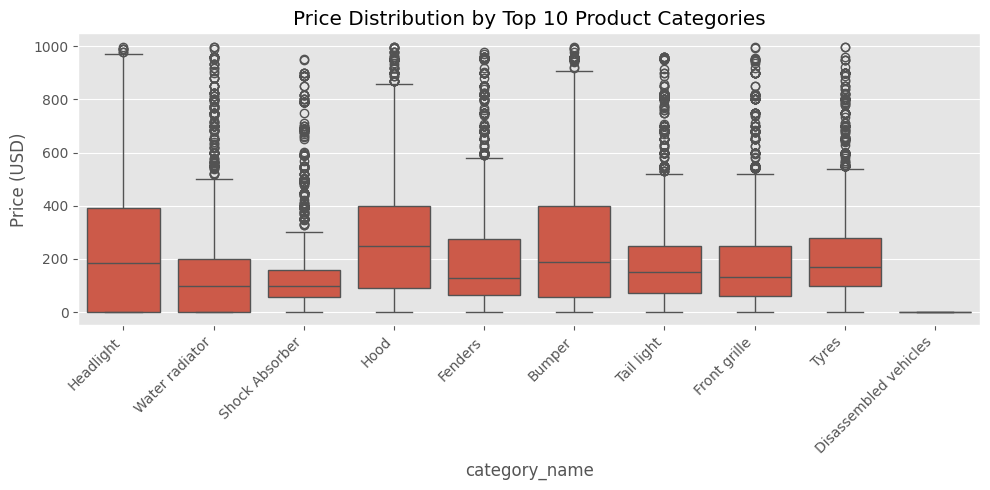

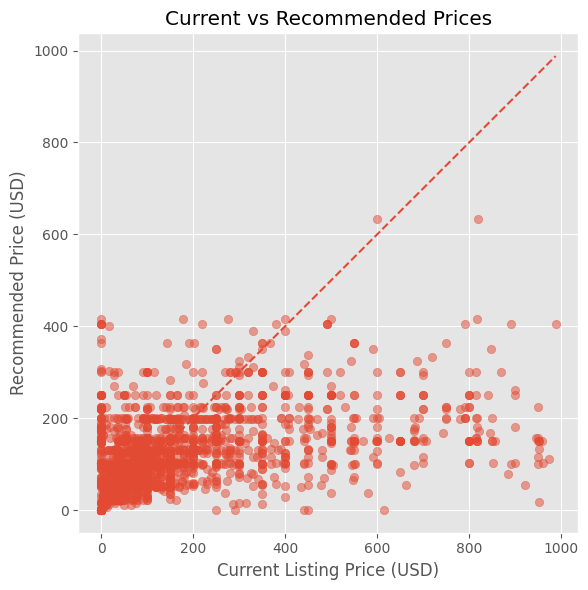

In [37]:
# Visual Insights
#1
top_categories = (
    apps["category_name"]
    .value_counts()
    .head(10)
    .index
)

plt.figure(figsize=(10, 5))
sns.boxplot(
    data=apps[apps["category_name"].isin(top_categories)],
    x="category_name",
    y="price_usd_filled"
)
plt.xticks(rotation=45, ha="right")
plt.title("Price Distribution by Top 10 Product Categories")
plt.ylabel("Price (USD)")
plt.tight_layout()
plt.show()

#2
sample = apps.sample(min(2000, len(apps)), random_state=42)  # sample to avoid huge plots

plt.figure(figsize=(6, 6))
plt.scatter(sample["price_usd_filled"], sample["recommended_price_usd"], alpha=0.5)
plt.plot([sample["price_usd_filled"].min(), sample["price_usd_filled"].max()],
         [sample["price_usd_filled"].min(), sample["price_usd_filled"].max()],
         linestyle="--")
plt.xlabel("Current Listing Price (USD)")
plt.ylabel("Recommended Price (USD)")
plt.title("Current vs Recommended Prices")
plt.tight_layout()
plt.show()



In [38]:
# Build Star Schema Tables (Load Step)
'''We’ll create:
dim_seller
dim_category
dim_vehicle_type
dim_status
dim_date (from application register date)
fact_applications_pricing'''

# Dimension: Seller
dim_seller = seller_clean.copy()
dim_seller.rename(columns={"id": "seller_key"}, inplace=True)

# Dimension: Category
dim_category = product_category_clean.copy()
dim_category.rename(columns={"id": "category_key"}, inplace=True)

# Dimension: Vehicle Type
dim_vehicle_type = vehicle_type_clean.copy()
dim_vehicle_type.rename(columns={"id": "vehicle_type_key"}, inplace=True)

# Dimension: Status
dim_status = application_status_clean.copy()
dim_status.rename(columns={"id": "status_key"}, inplace=True)

# Dimension: Date (based on app_register_date)
date_df = (
    apps[["app_register_date"]]
    .dropna()
    .drop_duplicates()
    .rename(columns={"app_register_date": "date"})
)

date_df["date_key"] = date_df["date"].dt.strftime("%Y%m%d").astype(int)
date_df["year"] = date_df["date"].dt.year
date_df["month"] = date_df["date"].dt.month
date_df["day"] = date_df["date"].dt.day
date_df["year_month"] = date_df["date"].dt.to_period("M").astype(str)

dim_date = date_df[["date_key", "date", "year", "month", "day", "year_month"]]

# Fact table: Applications Pricing
fact_cols = [
    "app_id",
    "headline",
    "seller_id",
    "category_id",
    "vehicle_type_id",
    "status_id",
    "price_usd_filled",
    "market_median_price",
    "market_mean_price",
    "recommended_price_usd",
    "delta_vs_market_median",
    "delta_vs_recommended",
    "target_margin_pct",
    "recommended_margin_pct",
    "market_position",
    "item_condition",
    "app_register_date",
]

fact_applications_pricing = apps[fact_cols].copy()

# Create foreign key replacements
fact_applications_pricing["date_key"] = fact_applications_pricing["app_register_date"].dt.strftime("%Y%m%d").astype(float)
fact_applications_pricing["date_key"] = fact_applications_pricing["date_key"].astype("Int64")  # nullable int

fact_applications_pricing.rename(
    columns={
        "seller_id": "seller_key",
        "category_id": "category_key",
        "vehicle_type_id": "vehicle_type_key",
        "status_id": "status_key",
    },
    inplace=True,
)

fact_applications_pricing.head()


,app_id,headline,seller_key,category_key,vehicle_type_key,status_key,price_usd_filled,market_median_price,market_mean_price,recommended_price_usd,delta_vs_market_median,delta_vs_recommended,target_margin_pct,recommended_margin_pct,market_position,item_condition,app_register_date,date_key
0,10074150,SUZUKI Grand Vitara 1996,581148,531,1,1,9,20.0,44.872093,20.80,-11.0,-11.80,0.3,0.3,Below Market (Cheap),New,2024-09-18,20240918
1,10101861,FORD / MERCURY / LINCOLN,581148,531,1,1,5,20.0,44.872093,20.80,-15.0,-15.80,0.3,0.3,Below Market (Cheap),New,2024-09-18,20240918
2,10101874,MAZDA Mazda 3 / CX-5,581148,531,1,1,13,20.0,44.872093,20.80,-7.0,-7.80,0.3,0.3,Below Market (Cheap),New,2024-09-18,20240918
3,10107865,MAZDA Protege 1998-2004,581148,334,1,1,36,66.0,64.945455,68.64,-30.0,-32.64,0.3,0.3,Below Market (Cheap),New,2024-09-18,20240918
4,10107874,MAZDA MPV / Protege,581148,531,1,1,11,20.0,44.872093,20.80,-9.0,-9.80,0.3,0.3,Below Market (Cheap),New,2024-09-18,20240918


In [39]:
OUTPUT_DIR = Path("star_schema_output")
OUTPUT_DIR.mkdir(exist_ok=True)

dim_seller.to_csv(OUTPUT_DIR / "dim_seller.csv", index=False)
dim_category.to_csv(OUTPUT_DIR / "dim_category.csv", index=False)
dim_vehicle_type.to_csv(OUTPUT_DIR / "dim_vehicle_type.csv", index=False)
dim_status.to_csv(OUTPUT_DIR / "dim_status.csv", index=False)
dim_date.to_csv(OUTPUT_DIR / "dim_date.csv", index=False)
fact_applications_pricing.to_csv(OUTPUT_DIR / "fact_applications_pricing.csv", index=False)

print("Star schema tables saved in:", OUTPUT_DIR.resolve())


Star schema tables saved in: C:\Internship_Projects\star_schema_output
